In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from scipy.optimize import fsolve

from dask.distributed import Client

%matplotlib inline

In [2]:
### Dask client
client = Client(n_workers=8)
display(client)

### Generate new session
db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 90.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45409,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 90.00 GiB
Comm: tcp://127.0.0.1:35797,Total threads: 1
Dashboard: /proxy/33019/status,Memory: 11.25 GiB
Nanny: tcp://127.0.0.1:38645,


### ACCESS-OM2

In [3]:
yr_beg = '2100-02-01'
yr_end = '2119-12-31'
var = 'temp_global_ave'
frequency = '1 daily'

expt = '1deg_jra55_ryf_cont'
access_cont_kbv = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_cool_x1_kbv'
access_cool_kbv = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_warm_x1_kbv'
access_warm_kbv = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

In [4]:
yr_beg = '2100-02-01'
yr_end = '2119-12-31'
var = 'temp_global_ave'
frequency = '1 daily'

expt = '1deg_jra55_ryf_cont_kb4'
access_cont_kb4 = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_cool_x1_kb4'
access_cool_kb4 = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_warm_x1_kb4'
access_warm_kb4 = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

In [5]:
yr_beg = '2100-02-01'
yr_end = '2119-12-31'
var = 'temp_global_ave'
frequency = '1 daily'

expt = '1deg_jra55_ryf_cont_nokb'
access_cont_nokb = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_cool_x1_nokb'
access_cool_nokb = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

expt = '1deg_jra55_ryf_warm_x1_nokb'
access_warm_nokb = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').groupby('time.year').mean(dim='time').load()

### 1D model

In [6]:
# Constants, data, parameters

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-6
mu = 1/(5 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz / 2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

# Analytical steady state, cf. Appendix 1

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (i.e., need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top / bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking for simplicity 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top / bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e., evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e., evaluated at the top / bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T


### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        ACCESS_ave_depth = 3642
        
        OHC[i] = z_b / ACCESS_ave_depth * np.mean(T[:, i]) # This is for average temperature
        
    return OHC


### Yearly average in order to plot on same time axes as ACCESS experiments

def onedim_yearly_ave(depth_ave_temp):
    
    time_steps_per_year = np.int(depth_ave_temp[1 : ].shape[0] / years)
    
    return np.array([np.mean(depth_ave_temp[time_steps_per_year * i : time_steps_per_year * (i + 1)]) for i in range(years)])

### Solving numerically for mu (for when using different kappa)

def eqn(mu, kappa):
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # C_1
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # The equation
    T_b_final = T_b + 0.5
    
    equation = T_b_final - T_b - 2 * np.exp(np.sqrt(mu / kappa) * z_b) * c_1 - np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b)
    
    return equation 

In [7]:
### Run experiment for k = 5x10-6

years = 20
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q = np.append(0, np.zeros(int(years * 360 / days)))
T0 = np.append(0, np.zeros(int(years * 360 / days)))
onedim_cont_kb6 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q, T0, years)

# Step function perturbation

Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

onedim_cool_kb6 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, - Q, - T0, years)
onedim_warm_kb6 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q, T0, years)

onedim_cont_kb6 = OHC(onedim_cont_kb6)
onedim_cool_kb6 = OHC(onedim_cool_kb6)
onedim_warm_kb6 = OHC(onedim_warm_kb6)

In [8]:
kappa = 1e-4
dt = 1.0 * 86400 # units: s

# Calculate deep restoring given kappa and no more than 0.5C drift
mu_initial_guess = 1 / (5 * 365 * 86400) # 1 / 5 years^-1
mu_numerical_soln = fsolve(eqn, mu_initial_guess, kappa)
mu = mu_numerical_soln[0]
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)

### Run experiment for k = 1x10-4

days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q = np.append(0, np.zeros(int(years * 360 / days)))
T0 = np.append(0, np.zeros(int(years * 360 / days)))
onedim_cont_kb4 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q, T0, years)

# Step function perturbation

Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

onedim_cool_kb4 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, - Q, - T0, years)
onedim_warm_kb4 = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q, T0, years)

onedim_cont_kb4 = OHC(onedim_cont_kb4)
onedim_cool_kb4 = OHC(onedim_cool_kb4)
onedim_warm_kb4 = OHC(onedim_warm_kb4)

In [9]:
kappa = 0
dt = 10.0 * 86400 # units: s

### Run experiment for k = 0 (use T_i(z) as initial condiiton)

days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q = np.append(0, np.zeros(int(years * 360 / days)))
T0 = np.append(0, np.zeros(int(years * 360 / days)))
onedim_cont_nokb = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)

# Step function perturbation

Q = np.append(0, np.ones(int(years * 360 / days)) * 8.0)
T0 = np.append(0, np.ones(int(years * 360 / days)) * 1.0)

onedim_cool_nokb = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, - Q, - T0, years)
onedim_warm_nokb = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)

onedim_cont_nokb = OHC(onedim_cont_nokb)
onedim_cool_nokb = OHC(onedim_cool_nokb)
onedim_warm_nokb = OHC(onedim_warm_nokb)

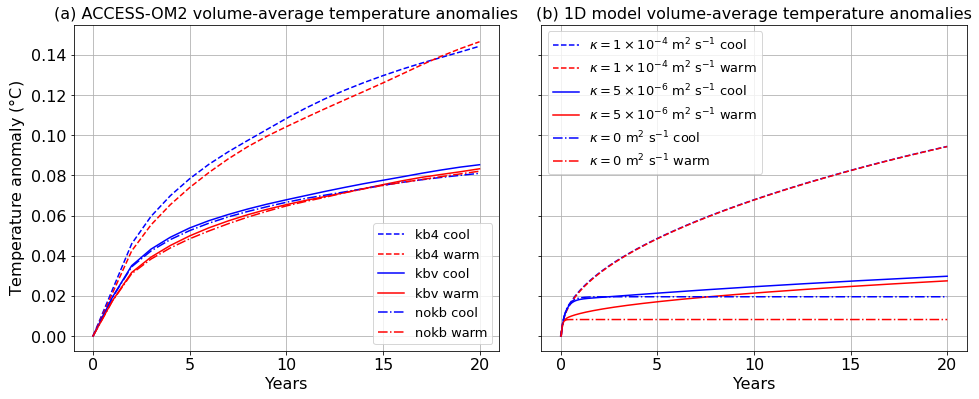

In [10]:
### Plot both ACCESS and 1D model volume-average temperatures and SSTs

### Time axis for 1D model arrays
timesteps = onedim_cont_kb6.shape[0]
length = (timesteps - 1) * 10 / 360
time_years_kb6 = np.linspace(0,length,timesteps)

timesteps = onedim_cont_kb4.shape[0]
length = (timesteps - 1) * 1 / 360
time_years_kb4 = np.linspace(0,length,timesteps)
###

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (16,6), sharey=True)
ymax = 0.155

fontsize=16

ax = axs[0]
ax.plot(- 1 * np.append(0,(access_cool_kb4 - access_cont_kb4).values.flatten()), color='b', label='kb4 cool', linestyle='--')
ax.plot(np.append(0,(access_warm_kb4 - access_cont_kb4).values.flatten()), color='r', label='kb4 warm', linestyle='--')
ax.plot(- 1 * np.append(0,(access_cool_kbv - access_cont_kbv).values.flatten()), color='b', label='kbv cool', linestyle='-')
ax.plot(np.append(0,(access_warm_kbv - access_cont_kbv).values.flatten()), color='r', label='kbv warm', linestyle='-')
ax.plot(- 1 * np.append(0,(access_cool_nokb - access_cont_nokb).values.flatten()), color='b', label='nokb cool', linestyle='-.')
ax.plot(np.append(0,(access_warm_nokb - access_cont_nokb).values.flatten()), color='r', label='nokb warm', linestyle='-.')

ax.set_title('(a) ACCESS-OM2 volume-average temperature anomalies', fontsize = fontsize)
ax.set_ylabel('Temperature anomaly ($\degree$C)', fontsize = fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('Years', fontsize = fontsize)
ax.set_ylim(None, ymax)
ax.grid()
ax.legend(loc='lower right', fontsize=fontsize-3)

ax = axs[1]
ax.plot(time_years_kb4, - 1 * (onedim_cool_kb4 - onedim_cont_kb4), color='b', label=r'$\kappa = 1\times10^{-4}$ m$^2$ s$^{-1}$ cool', linestyle='--')
ax.plot(time_years_kb4, (onedim_warm_kb4 - onedim_cont_kb4), color='r', label=r'$\kappa = 1\times10^{-4}$ m$^2$ s$^{-1}$ warm', linestyle='--')
ax.plot(time_years_kb6, - 1 * (onedim_cool_kb6 - onedim_cont_kb6), color='b', label=r'$\kappa = 5\times10^{-6}$ m$^2$ s$^{-1}$ cool', linestyle='-')
ax.plot(time_years_kb6, (onedim_warm_kb6 - onedim_cont_kb6), color='r', label=r'$\kappa = 5\times10^{-6}$ m$^2$ s$^{-1}$ warm', linestyle='-')
ax.plot(time_years_kb6, - 1 * (onedim_cool_nokb - onedim_cont_nokb), color='b', label=r'$\kappa = 0$ m$^2$ s$^{-1}$ cool', linestyle='-.')
ax.plot(time_years_kb6, (onedim_warm_nokb - onedim_cont_nokb), color='r', label=r'$\kappa = 0$ m$^2$ s$^{-1}$ warm', linestyle='-.')

ax.set_title('(b) 1D model volume-average temperature anomalies', fontsize = fontsize)
ax.set_ylabel('', fontsize = fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('Years', fontsize = fontsize)
ax.set_ylim(None, ymax)
ax.grid()
ax.legend(loc='upper left', fontsize=fontsize-3)

plt.subplots_adjust(wspace=0.1, hspace=0)

plt.savefig('Fig11.pdf', bbox_inches='tight', dpi=300)

Define a nonlinearity metric for any variable, $x$ $$n_x(t) = \frac{x'_c + x'_w}{(|x'_c| + |x'_w|)/ 2}$$ where primes denote anomalies and subscripts denote cooling or warming, and cooling anomalies have _not_ been multiplied by $-1$ in this notation; i.e., $n_x(t)$ measures the size of the nonlinear response divided by the average magnitude of response.

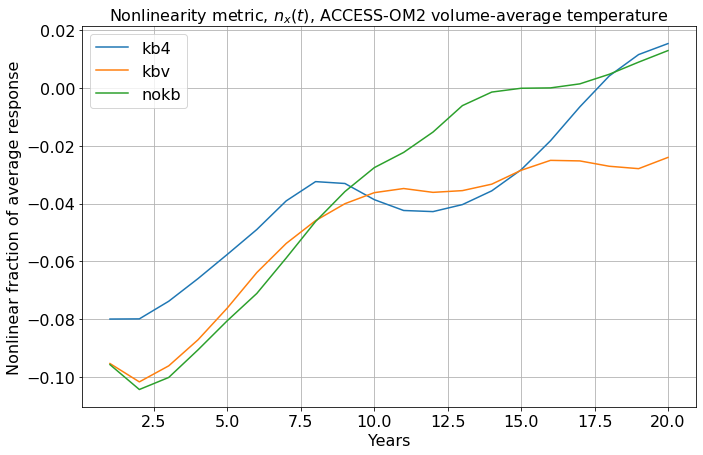

In [6]:
plt.figure(figsize=(11,7))

# plt.plot(np.linspace(1,20,20), access_cool_kb4 - access_cont_kb4 + access_warm_kb4 - access_cont_kb4, label='kb4')
# plt.plot(np.linspace(1,20,20), access_cool_kbv - access_cont_kbv + access_warm_kbv - access_cont_kbv, label='kbv')
# plt.plot(np.linspace(1,20,20), access_cool_nokb - access_cont_nokb + access_warm_nokb - access_cont_nokb, label='nokb')

plt.plot(np.linspace(1,20,20), (access_cool_kb4 - access_cont_kb4 + access_warm_kb4 - access_cont_kb4) / ((np.abs(access_cool_kb4 - access_cont_kb4) + np.abs(access_warm_kb4 - access_cont_kb4))/2), label='kb4')
plt.plot(np.linspace(1,20,20), (access_cool_kbv - access_cont_kbv + access_warm_kbv - access_cont_kbv) / ((np.abs(access_cool_kbv - access_cont_kbv) + np.abs(access_warm_kbv - access_cont_kbv))/2), label='kbv')
plt.plot(np.linspace(1,20,20), (access_cool_nokb - access_cont_nokb + access_warm_nokb - access_cont_nokb) / ((np.abs(access_cool_nokb - access_cont_nokb) + np.abs(access_warm_nokb - access_cont_nokb))/2), label='nokb')

# plt.plot(time_years_kb4, (onedim_cool_kb4 - onedim_cont_kb4 + onedim_warm_kb4 - onedim_cont_kb4) / ((np.abs(onedim_cool_kb4 - onedim_cont_kb4) + np.abs(onedim_warm_kb4 - onedim_cont_kb4))/2), label='kb4')
# plt.plot(time_years_kb6, (onedim_cool_kb6 - onedim_cont_kb6 + onedim_warm_kb6 - onedim_cont_kb6) / ((np.abs(onedim_cool_kb6 - onedim_cont_kb6) + np.abs(onedim_warm_kb6 - onedim_cont_kb6))/2), label='kb6')
# plt.plot(time_years_kb6, (onedim_cool_nokb - onedim_cont_nokb + onedim_warm_nokb - onedim_cont_nokb) / ((np.abs(onedim_cool_nokb - onedim_cont_nokb) + np.abs(onedim_warm_nokb - onedim_cont_nokb))/2), label='nokb')

fontsize=16
# plt.title(r"Absolute size of nonlinearity ($x'_c + x'_w)$, ACCESS-OM2 volume-average temperature",fontsize=fontsize)
plt.title(r'Nonlinearity metric, $n_x(t)$, ACCESS-OM2 volume-average temperature', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xlabel('Years',fontsize=fontsize)
# plt.ylabel('Temperature ($\degree$C)',fontsize=fontsize)
plt.ylabel('Nonlinear fraction of average response', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid()

plt.savefig('Fig11a.pdf', bbox_inches='tight', dpi=300)